In [1]:
%run init_notebook.py

In [2]:
import pymc as pm

In [3]:
from src.utils import load_pd_df, save_pd_df, get_dt_index, pd_join_freq
from src.processing import pd_groupby, pd_join_dfs
from src.pymc_modelling import get_samp

from linearmodels.panel import PanelOLS
from linearmodels import RandomEffects
from statsmodels.tsa.vector_ar.var_model import VAR

In [4]:
# load

In [5]:
hhp = load_pd_df('hhp_processed.feather')
topics = load_pd_df('lda_topics_smooth.feather')
infl = get_dt_index(load_pd_df('de_inf_prepro.csv')).sort_index()

hhp['delta_pe'] = hhp['pi_perc'] - hhp['pi_exp']

In [6]:
df = pd_join_freq(
    hhp.set_index('date_recorded')[[
        'date_forecast', 'pi_perc', 'pi_perc_WY', 'delta_pe', 'debt_delta', 'is_homeown_delta', 'is_unempl_delta', 'hhinc_delta', 'id',
        'hhinc_midpoint',
    ]].copy(),
    infl,
    'M',
    keep_left_index=True).copy()

In [7]:
df['week_recorded'] = df.index.to_period('W').to_timestamp()
df['pi_perc_WY_error'] = df['pi_de_Y'] - df['pi_perc_WY']

In [8]:
cols = ['D_inflation_W_diff', "D_inflation_W"]
df = pd_join_freq(df, topics[cols].drop_duplicates(), "D", keep_left_index=True, how='left')

In [9]:
df = df.sort_index() 
df[cols] = df[cols].ffill()

# VAR pi_perc_error

In [10]:
reg = df[["D_inflation_W", 'pi_perc_WY_error']].dropna().drop_duplicates().copy()
reg['W'] = reg.index.to_period("W").to_timestamp()
reg = reg.reset_index().groupby('W').last()

reg = reg.drop('date_recorded', axis=1)
reg = reg.diff().dropna()

<AxesSubplot: xlabel='W'>

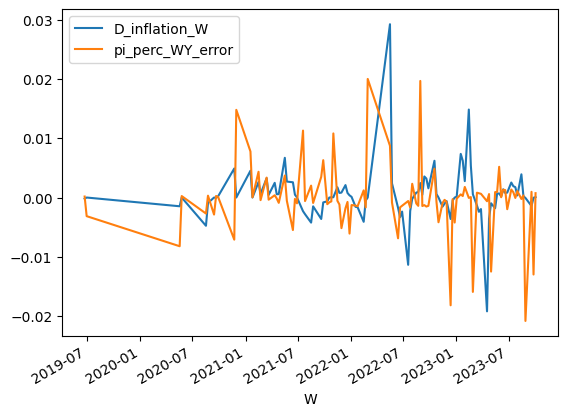

In [11]:
reg.plot()

In [12]:
var = VAR(reg).fit()
var.summary()

C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 08, Mar, 2024
Time:                     11:57:37
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -21.0241
Nobs:                     100.000    HQIC:                  -21.1172
Log likelihood:           781.234    FPE:                6.33093e-10
AIC:                     -21.1804    Det(Omega_mle):     5.96751e-10
--------------------------------------------------------------------
Results for equation D_inflation_W
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                       0.000463         0.000432            1.070           0.285
L1.D_inflation_W            0.220418         0.095221            2.315           0.021
L1.pi_perc_WY_error         

# Exp 1

Investigate the effect of news $N_t$ on inflation perception $\pi^p_{i,t}$:
$$ \pi^p_{i,t} = \alpha_i + \beta N_t + \gamma X_{i,t} + \epsilon_{i,t} $$

In [143]:
cols = ['D_inflation_W', 'hhinc_delta', 'pi_de_Y', 'debt_delta',]# 'is_unempl_delta', 'is_homeown_delta']
ind_cols = ['id', 'date_recorded']
dep_col = ['pi_perc']

In [144]:
sub = df[ind_cols + cols + dep_col].copy().reset_index(drop=True)

# only consider respondents with over 5 obs
filt = sub.set_index(ind_cols)[dep_col].dropna().unstack().count(axis=1) > 8
sub = sub.loc[sub.id.isin(filt[filt].index)].sort_values(ind_cols[1])

sub = sub.sort_values(ind_cols).dropna()
# sub = sub.set_index(ind_cols).sort_index().dropna()
sub.shape

(689, 7)

In [145]:
sub['M'] = sub.date_recorded.dt.to_period('M').dt.to_timestamp()

In [146]:
sub = sub.groupby(['id', 'M']).last().drop('date_recorded', axis=1)

In [147]:
sub = sub.drop_duplicates()

<AxesSubplot: xlabel='M'>

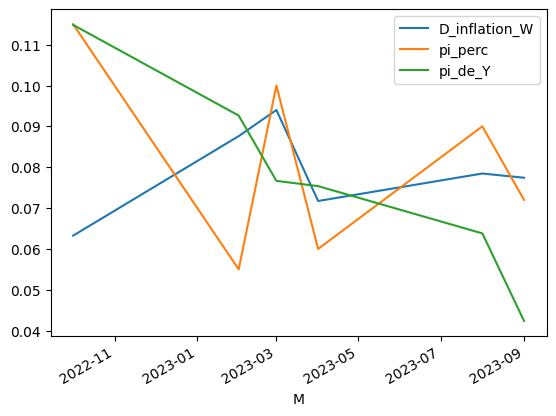

In [148]:
sub.loc[sub.index.get_level_values(0)[2]][['D_inflation_W', 'pi_perc', 'pi_de_Y']].plot()

In [149]:
m_fe = PanelOLS(sub[dep_col], sub[cols], entity_effects=True).fit(cov_type='clustered', cluster_entity=True)
m_re = RandomEffects(sub[dep_col], sub[cols]).fit()

In [150]:
print(m_fe)

                          PanelOLS Estimation Summary                           
Dep. Variable:                pi_perc   R-squared:                        0.0473
Estimator:                   PanelOLS   R-squared (Between):              0.6767
No. Observations:                 453   R-squared (Within):               0.0473
Date:                Fri, Mar 08 2024   R-squared (Overall):              0.6509
Time:                        12:08:34   Log-likelihood                    1210.0
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      4.1585
Entities:                         114   P-value                           0.0027
Avg Obs:                       3.9737   Distribution:                   F(4,335)
Min Obs:                       1.0000                                           
Max Obs:                       7.0000   F-statistic (robust):             5.6929
                            

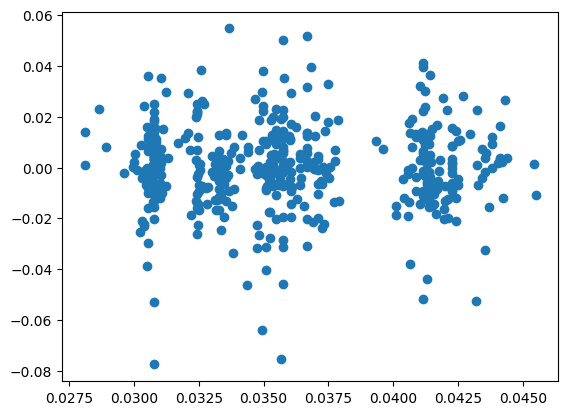

In [151]:
plt.scatter(m_fe.predict().values, m_fe.resids.values)

In [152]:
from statsmodels.stats.diagnostic import het_white, het_breuschpagan

In [153]:
_ = pd.concat([m_fe.resids, sub[cols]], axis=1)
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print(dict(zip(labels, het_breuschpagan(_['residual'], _.drop('residual', axis=1)))))

{'LM-Stat': 79.55631769597416, 'LM p-val': 3.821220330519152e-17, 'F-Stat': 23.913101451540683, 'F p-val': 5.986361912284834e-18}


In [154]:
from statsmodels.stats.stattools import durbin_watson
durbin_watson_test_results = durbin_watson(m_fe.resids) 
print(durbin_watson_test_results)

2.4120839723788907


In [155]:
import scipy

In [156]:
def hausman(fe, re):
    b = fe.params
    B = re.params
    v_b = fe.cov
    v_B = re.cov
    df = b[np.abs(b) < 1e8].size
    chi2 = np.dot((b - B).T, np.linalg.inv(v_b - v_B).dot(b - B)) 
    
    pval = scipy.stats.chi2.sf(chi2, df)
    return chi2, df, pval

In [157]:
hausman(m_fe, m_re)
hausman_results = hausman(m_fe, m_re)
print('chi-Squared: ' + str(hausman_results[0]))
print('degrees of freedom: ' + str(hausman_results[1]))
print('p-Value: ' + str(hausman_results[2]))

chi-Squared: 47.937745337878006
degrees of freedom: 4
p-Value: 9.724108524342391e-10


# Exp 2

Influence of news on future change in inflation $\pi^e_{i,t} - \pi^p_{i,t}$
$$ \pi^e_{i,t} - \pi^p_{i,t} = \alpha_i + \beta N_t + \gamma X_{i,t} + \epsilon_{i,t} $$

In [112]:
cols = ['D_inflation_W', 'hhinc_delta', 'pi_de_Y', 'debt_delta', 'is_unempl_delta', 'is_homeown_delta']
ind_cols = ['id', 'week_recorded']
dep_col = ['delta_pe']

In [113]:
sub = df[ind_cols + cols + dep_col].drop_duplicates().copy().reset_index()

# only consider respondents with over 5 obs
filt = sub.set_index(ind_cols)[dep_col].dropna().unstack().count(axis=1) > 7
sub = sub.loc[sub.id.isin(filt[filt].index)].sort_values(ind_cols[1])

sub = sub.set_index(ind_cols).sort_index().dropna()
# sub = sub[~sub[dep_col].isna()].dropna()

In [114]:
sub.shape

(2495, 8)

In [115]:
m_fe = PanelOLS(sub[dep_col], sub[cols], entity_effects=True).fit(cov_type='clustered', cluster_entity=True)

In [116]:
print(m_fe)

                          PanelOLS Estimation Summary                           
Dep. Variable:               delta_pe   R-squared:                        0.1258
Estimator:                   PanelOLS   R-squared (Between):              0.1398
No. Observations:                2495   R-squared (Within):               0.1258
Date:                Fri, Mar 08 2024   R-squared (Overall):              0.1305
Time:                        11:34:18   Log-likelihood                    6088.9
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      49.172
Entities:                         439   P-value                           0.0000
Avg Obs:                       5.6834   Distribution:                  F(6,2050)
Min Obs:                       2.0000                                           
Max Obs:                       8.0000   F-statistic (robust):             41.180
                            

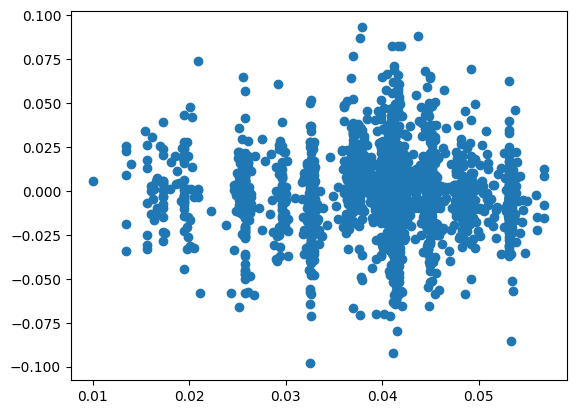

In [94]:
plt.scatter(m_fe.predict().values, m_fe.resids.values)

# Exp 3

Influence of news on perception gap $\pi^p_{i,t} - \pi_{i,t}$
$$ \pi^p_{i,t} - \pi_{i,t} = \alpha_i + \beta N_t + \gamma X_{i,t} + \epsilon_{i,t} $$

In [135]:
cols = ['D_inflation_W', 'hhinc', 'pi_de_Y', 'debt_delta', 'is_unempl_delta', 'is_homeown_delta']
ind_cols = ['id', 'week_recorded']
dep_col = ['pi_perc_WY_error']

In [136]:
sub = df[ind_cols + cols + dep_col].drop_duplicates().copy().reset_index()

# only consider respondents with over 5 obs
filt = sub.set_index(ind_cols)[dep_col].dropna().unstack().count(axis=1) > 8
sub = sub.loc[sub.id.isin(filt[filt].index)].sort_values(ind_cols[1])

sub = sub.set_index(ind_cols).sort_index().dropna()
# sub = sub[~sub[dep_col].isna()].dropna()

KeyError: "['hhinc'] not in index"

In [ ]:
sub = sub.drop_duplicates()

In [131]:
sub.shape

(4905, 8)

In [132]:
m_fe = PanelOLS(sub[dep_col], sub[cols], entity_effects=True).fit(cov_type='clustered', cluster_entity=True)

In [133]:
print(m_fe)

                          PanelOLS Estimation Summary                           
Dep. Variable:       pi_perc_WY_error   R-squared:                        0.7869
Estimator:                   PanelOLS   R-squared (Between):             -0.9850
No. Observations:                4905   R-squared (Within):               0.7869
Date:                Fri, Mar 08 2024   R-squared (Overall):             -0.7194
Time:                        11:36:05   Log-likelihood                 1.892e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1419.4
Entities:                        2592   P-value                           0.0000
Avg Obs:                       1.8924   Distribution:                  F(6,2307)
Min Obs:                       1.0000                                           
Max Obs:                       11.000   F-statistic (robust):             2348.2
                            

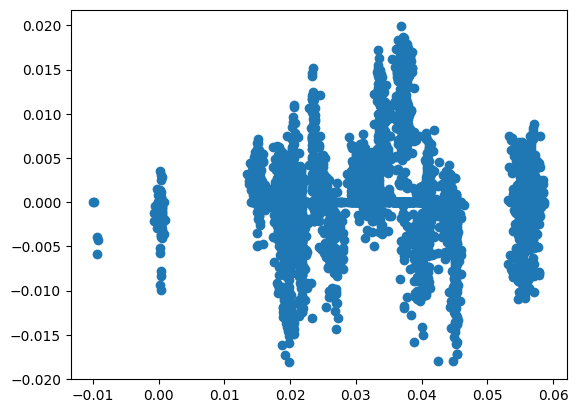

In [134]:
plt.scatter(m_fe.predict().values, m_fe.resids.values)